## load libraries

In [ ]:
import torch
torch.cuda.set_device(2)
torch.cuda.current_device()
import pandas as pd
import numpy as np
from langdetect import detect
import re

from medner import MedNER
from medlinker import MedLinker
from umls import umls_kb_st21pv as umls_kb
import json
from nltk.stem import WordNetLemmatizer 
import nltk
import yaml

## read  metadata

In [3]:
import pandas as pd
meta = pd.read_csv('/home/dhamzeia/Data/metadata.csv')
# meta = meta['abstract']


# calculate the number of empty documents
#empty = 0
# # from langdetect import detect

# for i, m in enumerate(meta):
#     if str(m)=='nan':
#         empty+=1
#         continue
# print(empty)
    
# 414020 of the abstracts are empty

/opt/anaconda3/2019-03/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## load medlinker models (NER + EL) for preprocessing

In [ ]:


# default models, best configuration from paper
# to experiment with different configurations, just comment/uncomment components

cx_ner_path = 'models/ContextualNER/mm_st21pv_SCIBERT_uncased/'
em_ner_path = 'models/ExactMatchNER/umls.2017AA.active.st21pv.nerfed_nlp_and_matcher.max3.p'
ngram_db_path = 'models/SimString/umls.2017AA.active.st21pv.aliases.3gram.5toks.db'
ngram_map_path = 'models/SimString/umls.2017AA.active.st21pv.aliases.5toks.map'
st_vsm_path = 'models/VSMs/mm_st21pv.sts_anns.scibert_scivocab_uncased.vecs'
cui_vsm_path = 'models/VSMs/mm_st21pv.cuis.scibert_scivocab_uncased.vecs'
cui_clf_path = 'models/Classifiers/softmax.cui.h5'
sty_clf_path = 'models/Classifiers/softmax.sty.h5'
cui_val_path = 'models/Validators/mm_st21pv.lr_clf_cui.dev.joblib'
sty_val_path = 'models/Validators/mm_st21pv.lr_clf_sty.dev.joblib'

print('Loading MedNER ...')
medner = MedNER(umls_kb)
medner.load_contextual_ner(cx_ner_path, 2)

print('Loading MedLinker ...')
medlinker = MedLinker(medner, umls_kb)

medlinker.load_string_matcher(ngram_db_path, ngram_map_path)  # simstring approximate string matching

# medlinker.load_st_VSM(st_vsm_path)
medlinker.load_sty_clf(sty_clf_path)
# medlinker.load_st_validator(sty_val_path, validator_thresh=0.45)

# medlinker.load_cui_VSM(cui_vsm_path)
medlinker.load_cui_clf(cui_clf_path)
# medlinker.load_cui_validator(cui_val_path, validator_thresh=0.70)



## An example of MedLinker's output

In [7]:
sent = '''The severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) pandemic was first reported in Wuhan, China in December 2019, moved across the globe at an unprecedented speed, and is having a profound and yet still unfolding health and socioeconomic impacts. SARS-CoV-2, a β-coronavirus, is a highly contagious respiratory pathogen that causes a disease that has been termed the 2019 coronavirus disease (COVID-19). Clinical experience thus far indicates that COVID-19 is highly heterogeneous, ranging from being asymptomatic and mild to severe and causing death. Host factors including age, sex, and comorbid conditions are key determinants of disease severity and progression. Aging itself is a prominent risk factor for severe disease and death from COVID-19. We hypothesize that age-related decline and dysregulation of immune function, i.e., immunosenescence and inflammaging play a major role in contributing to heightened vulnerability to severe COVID-19 outcomes in older adults. Much remains to be learned about the immune responses to SARS-CoV-2 infection. We need to begin partitioning all immunological outcome data by age to better understand disease heterogeneity and aging. Such knowledge is critical not only for understanding of covid-19 pathogenesis but also for COVID-19 vaccine development.'''
medlinker.predict(sent)


{'sentence': 'The severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) pandemic was first reported in Wuhan, China in December 2019, moved across the globe at an unprecedented speed, and is having a profound and yet still unfolding health and socioeconomic impacts. SARS-CoV-2, a β-coronavirus, is a highly contagious respiratory pathogen that causes a disease that has been termed the 2019 coronavirus disease (COVID-19). Clinical experience thus far indicates that COVID-19 is highly heterogeneous, ranging from being asymptomatic and mild to severe and causing death. Host factors including age, sex, and comorbid conditions are key determinants of disease severity and progression. Aging itself is a prominent risk factor for severe disease and death from COVID-19. We hypothesize that age-related decline and dysregulation of immune function, i.e., immunosenescence and inflammaging play a major role in contributing to heightened vulnerability to severe COVID-19 outcomes in older adult

In [44]:
### Do some preprocessing before medlinker: remove numbers/floats/ratio/all_capitals/Non_english& empty abstracts

In [ ]:
# t = re.findall('([A-Z]{4,})', text)
# elapsed time: 85s for 100 docs. for 400k would be >90h!
medlinked = []
non_english = 0
empty =0
predicted_index = []

for i, text in enumerate(meta['abstract']):
    if i <150000:
        continue
    print(i)
    print('medlinked is: {}'.format(len(medlinked)))
    if i in predicted_index:
        continue
    if text=='' or str(text)=='nan': 
        empty+=1
        print(text)
        continue
    try:
        lang= detect(text)
        if lang!= 'en':
            non_english +=1
            continue
    except Exception as e:
        print(text)
        print(e)
        empty+=1
        continue



    
    sent_text = nltk.sent_tokenize(text)
    for sent in sent_text:
        sent = re.sub(r'(PATIENTS|STATISTICAL|ANALYSIS|SETTING|REVIEWERS|QUESTIONS|PURPOSES|PURPOSE|EXPERIMENTAL|DESIGN|RELEVANCE|CLINICAL|ENHANCED|VERSION|REGISTRATION|MATERIALS|ELECTRONIC|MATERIAL|PRESENTATION|OBJECTIVE|METHODS|CONCLUSION|RESULTS|BACKGROUND|INTRODUCTION|DISCUSSION|SIGNIFICANCE|DESCRIPTION|ABSTRACT|METHODOLOGY|PRINCIPAL|FINDINGS|INFORMATION|SUPPLEMENTARY|SUMMARY)', ' ', sent)
        sent = re.sub(r"\d+\.\d+",' ', sent)
        sent = re.sub(r"\d+\.\d+%",' ', sent)
        sent = re.sub(r"\d+\,\d+",' ', sent)
        sent = re.sub(r"\.\d+",' ', sent)
        sent = re.sub(r"\,\d+",' ', sent)
        sent= re.sub(r' [0-9]+ ','  ',sent)
        sent = re.sub(r'\[.*?\]', '', sent)
        sent = re.sub(r'[0-9]+%',' ', sent)
        if len(sent)>10 and len(sent)< 1000:
            r = medlinker.predict(sent)
            r['index'] = i
            medlinked.append(r)
            predicted_index.append(i)

#     except Exception as e:
#         print(text)
#         print(e)
    
    
    

In [11]:
print('until i= {}, empty= {}, and non_english = {}, predicted = {}'.format(i, empty, non_english, len(set(predicted_index))))
#until i= 52309, empty= 17737, and non_english = 998
#until i= 56384, empty= 18726, and non_english = 1015, predicted = 36832
#from i = 150k until  i= 241807, empty= 31170, and non_english = 1732, predicted = 47241


until i= 241807, empty= 31170, and non_english = 1732, predicted = 47241


In [25]:
#save medlinked to csv
medlinked_df = pd.DataFrame(medlinked)   
medlinked_df.to_csv('medlinked_testset.csv')

In [27]:
# read medlinked. medlinked was applied on sentences. We need to combine them to form a abstract
import pandas as pd
import numpy as np
medlinked_df = pd.read_csv('medlinked_testset.csv' )
medlinked_df.head()

,Unnamed: 0,sentence,tokens,spans,index
0,0,Extreme prolonged drought over south-eastern A...,"['Extreme', 'prolonged', 'drought', 'over', 's...","[{'start': 4, 'end': 6, 'text': 'south-eastern...",150001
1,1,Whilst the significant release of metal-enrich...,"['Whilst', 'the', 'significant', 'release', 'o...","[{'start': 5, 'end': 6, 'text': 'metal-enriche...",150001
2,2,"Here we investigate the spatial distribution, ...","['Here', 'we', 'investigate', 'the', 'spatial'...","[{'start': 12, 'end': 14, 'text': 'S, Fe,', 's...",150001
3,3,The highest concentrations of all metals (Enri...,"['The', 'highest', 'concentrations', 'of', 'al...","[{'start': 5, 'end': 6, 'text': 'metals', 'st'...",150001
4,4,Localised enrichment indicates metals have not...,"['Localised', 'enrichment', 'indicates', 'meta...","[{'start': 3, 'end': 4, 'text': 'metals', 'st'...",150001


### Apply lemmatization, punctuation removal, and lowercase after medlinker

In [28]:
def clean(tok):
#     print("tok  " + tok)
    clean_tok = tok.lower()
    clean_chars = ''
    for ch in clean_tok:
        if ch in '0123456789abcdefghijklmnopqrstuvwxyz-':
            clean_chars+= ch
        else:
            clean_chars+=' '
    clean_tok = clean_chars
    clean_tok = clean_tok.strip()
    if clean_tok.lower() not in stopwords.words('english'):
        clean_tok = re.sub(r' [0-9]+ ','  ',clean_tok)
        clean_tok = re.sub(r'[0-9]+ ','  ',clean_tok)
        clean_tok = re.sub(r' [0-9]+','  ',clean_tok)
        clean_tok = re.sub(r'[0-9]+s','  ',clean_tok)
        clean_tok = re.sub(r'[0-9]+th','  ',clean_tok)
        clean_tok = clean_tok.strip()

        if clean_tok !='' and not clean_tok.isnumeric():

            if clean_tok!='eg' and clean_tok !='ie' and len(clean_tok)>1 and clean_tok not in stops:

                clean_tok = wordnet_lemmatizer.lemmatize(clean_tok, pos = 'n')
                clean_tok = wordnet_lemmatizer.lemmatize(clean_tok, pos = 'v')
                clean_tok = wordnet_lemmatizer.lemmatize(clean_tok, pos = 'a')
                if clean_tok[0] not in string.digits:
                    if clean_tok[0]=='-':
                        clean_tok = clean_tok[1:len(clean_tok)] 
                    return(clean_tok)
#                     updated_str+= ' '+clean_tok
    return ''
                

In [ ]:
#process medlinked
import string
from nltk.corpus import stopwords
exclude = set(string.punctuation)
# preprocessed = []
medlinked_df['preprocessed'] = ''
wordnet_lemmatizer = WordNetLemmatizer()
stops = stopwords.words('english')
for a in ['ii', 'iii', 'iv', 'vi', 'ix', 'vii', 'viii']:
    stops.append(a)
for row in range(len(medlinked_df)) :
    tokens, spans, sentence = medlinked_df['tokens'][row], medlinked_df['spans'][row], medlinked_df['sentence'][row]
    if medlinked_df['preprocessed'][row]!='':
        continue
    if row %100==0:
        print(row)
        
    last_end = 0
    updated_str = ''
    try:
        tokens = yaml.load(tokens)
        spans = yaml.load(spans)
    except Exception as e:
        print(e)
        print(row)
        continue
    if len(spans)>0:
        for sp in spans:
            start = sp['start']
            end = sp['end']
            cui = sp['cui']
            cui = cui[2:len(cui)-1]
    #         print(cui)
    #         print()
            for tok in tokens[last_end:start]:
#                 print(clean(tok))
                updated_str +=' ' + clean(tok)
            updated_str+=' '
            updated_str+= cui
            updated_str+=' '
            last_end = end

        if end < len(tokens):
            updated_str+= ' '
            for tok in tokens[end:len(tokens)]:
                updated_str+= ' '+clean(tok)
            
    else:
        for tok in tokens:
                updated_str +=' ' + clean(tok)
        
#             clean_tok = re.sub(re.compile('[!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~]'),' ', tok)
#             clean_tok = re.sub(r'•', ' ', clean_tok)
#             clean_tok = re.sub(r'’', ' ', clean_tok)
            
            
#     print(updated_str)

    medlinked_df['preprocessed'][row] = updated_str
#     preprocessed.append(updated_str)
# medlinked_df['preprocessed'] = preprocessed
#     print()
#     cov['tokens'][start:end] = reduce(cui)
#     print('----')
#     print(end)
#     print(cui)
#     print('---')

In [38]:
# save preprocessed& medlinked abstracts
medlinked_df.to_csv('medlinked_testset_prep.csv')

In [61]:
# aggregate the results of sentences to form abstracts again
agg_df = medlinked_df.groupby(['index'], as_index = False)['preprocessed'].agg({'prep_text': ' '.join})

# agg_df['original'] = meta['abstract'][agg_df['index']]
print(agg_df.head())
agg_df.to_csv('agg_df_testset.csv')

    index                                          prep_text
0  150001   extreme prolong drought  C0004340    decade a...
1  150002    recent C0546788   pandemic  cause unpreceden...
2  150004   C0078939   C0085401   currently represent  tw...
3  150007   C0001617  c C0021496   commonly use   C003313...
4  150013    early evidence indicate increase C0025353  b...


# read test and train documents (preprocessed) and add url, abstract and ID columns from meta dataframe

In [4]:
import pandas as pd
import numpy as np
agg_df = pd.read_csv('agg_df_56384.csv')
test_df = pd.read_csv('agg_df_testset.csv')
test_df = test_df.drop_duplicates(subset = ['prep_text']).reset_index(drop = True)
agg_df = agg_df.drop_duplicates(subset = ['prep_text']).reset_index(drop = True)
agg_df.loc[:, 'url'] = meta.loc[agg_df['index'].astype(int), 'url'].reset_index()
agg_df.loc[:, 'abstract'] = meta.loc[agg_df['index'].astype(int), 'abstract'].reset_index()
agg_df.loc[:, 'cord_uid'] = meta.loc[agg_df['index'].astype(int), 'cord_uid'].reset_index()
test_df= test_df.loc[test_df['prep_text'].astype(str)!='nan'].reset_index()
test_df.loc[:, 'url'] = meta.loc[test_df['index'].astype(int), 'url'].reset_index()
test_df.loc[:, 'abstract'] = meta.loc[test_df['index'].astype(int), 'abstract'].reset_index()
test_df.loc[:, 'cord_uid'] = meta.loc[test_df['index'].astype(int), 'cord_uid'].reset_index()
test_df.tail()

,level_0,Unnamed: 0,index,prep_text,url,abstract,cord_uid
43284,43285,47235,241800,association age high vulnerability C0546...,NaN,The association of age with a higher vulnerabi...,xet6b64x
43285,43286,47236,241801,outbreak C0010076 covid-19 C0008115 caus...,NaN,An outbreak of coronavirus disease (COVID-19) ...,7jakv2ge
43286,43287,47237,241802,increase C0038435 resilience C2936506 imp...,NaN,Increasing stress resilience of livestock is i...,vy8s51p9
43287,43288,47238,241803,context C0282574 pandemic highlight essen...,NaN,CONTEXT: The COVID-19 pandemic has highlighted...,fexdvnuj
43288,43289,47239,241804,C0031323 need effective communication skill ...,NaN,Pharmacists need effective communication skill...,djn6ltnu


## An example of a preprocessed document

In [34]:
print('original:')
print(test_df.loc[1, 'abstract'])
print()
print('preprocessed:')
print(test_df.loc[1, 'prep_text'])

original:
The recent COVID-19 pandemic has caused unprecedented impact across the globe. We have also witnessed millions of people with increased mental health issues, such as depression, stress, worry, fear, disgust, sadness, and anxiety, which have become one of the major public health concerns during this severe health crisis. For instance, depression is one of the most common mental health issues according to the findings made by the World Health Organisation (WHO). Depression can cause serious emotional, behavioural and physical health problems with significant consequences, both personal and social costs included. This paper studies community depression dynamics due to COVID-19 pandemic through user-generated content on Twitter. A new approach based on multi-modal features from tweets and Term Frequency-Inverse Document Frequency (TF-IDF) is proposed to build depression classification models. Multi-modal features capture depression cues from emotion, topic and domain-specific per

In [ ]:
# import spacy

# from scispacy.abbreviation import AbbreviationDetector

# nlp = spacy.load("en_core_web_sm")

# # Add the abbreviation pipe to the spacy pipeline.
# abbreviation_pipe = AbbreviationDetector(nlp)
# nlp.add_pipe(abbreviation_pipe)


abrvs = []
for i, text in enumerate(agg_df[ 'abstract']):
    doc = nlp(text)
    for abrv in doc._.abbreviations:
        abrvs.append(abrv)
    if i%100 ==0:
        print(i)
#         print(abrv)

In [23]:
abrvs_set = set([abrv.lower_ for abrv in abrvs])

In [28]:
import re
from sklearn.feature_extraction.text import CountVectorizer
def custom_tokenizer(txt):
    toks = []
    txt = str(txt)
    txt = txt.lower()
    for s in txt.split(' '):
        if len(s)<2:
            continue
        if s[0]=='-':
            if s[1]=='-':
                s= s[1:len(s)]
            s = s[1:len(s)]
        if len(s)<2:
            continue
        if s[len(s)-1]=='-':
            s= s[0:len(s)-1]
        if s.isnumeric():
            continue
        elif len(s)>2 and s not in abrvs_set:
            toks.append(s)
    return toks
count_vect = CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', max_features=10000)
X_train_counts = count_vect.fit_transform(agg_df['prep_text'])

In [ ]:
# check tokens of the dictionary (Vocabulary)
for v in sorted(count_vect.vocabulary_):
    if len(v)!= len("c0014507"):
        print(v)


## tokenize the train and test documents

In [29]:
word_tokenizer = count_vect.build_tokenizer()
texts = [word_tokenizer(doc) for doc in agg_df['prep_text']]
test_texts = [word_tokenizer(doc) for doc in test_df['prep_text']]

# tokenized_test_20 = [word_tokenizer(doc.lower()) for doc in twenty_test.data]
# texts[1]

# build dataset and the topic model

In [ ]:
from contextualized_topic_models.models.ctm import CTM
import os
import pickle
from contextualized_topic_models.utils.data_preparation import TextHandler
from contextualized_topic_models.datasets.dataset import CTMDataset, CTMNoBERTDataset
import time

tmp = {k: v for k, v in sorted(count_vect.vocabulary_.items(), key=lambda item: item[1])}
idx2token = dict((v,k) for k,v in tmp.items())
X_test_counts = count_vect.transform(test_df['prep_text'])
dataset = CTMNoBERTDataset(X_train_counts,  idx2token)
test_set = CTMNoBERTDataset(X_test_counts,  idx2token)
# # create the dataset

start = time.time()
ctm = CTM(input_size=len(count_vect.vocabulary_), bert_input_size=768, num_epochs=250, inference_type="noBERT", n_components=10, texts = texts, model_type='prodLDA')

ctm.fit(dataset, save_dir = 'saved_models/vocab_10k/', save_every = 25)
end = time.time()
print('elapsed time = {}'.format(end-start))

## load saved topic model

In [102]:
# path_2k_25 = "saved_models/vocab_2k/contextualized_topic_model_nc_25_tpm_0.0_tpv_0.96_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
# path_2k_10 = "saved_models/vocab_2k/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99"
# path_2k_50 = "saved_models/vocab_2k/contextualized_topic_model_nc_50_tpm_0.0_tpv_0.98_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"

# path_10k_10 = "saved_models/vocab_10k/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
path_10k_15 = "saved_models/vocab_10k/contextualized_topic_model_nc_15_tpm_0.0_tpv_0.9333333333333333_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99"


# path_10k_25 = "saved_models/vocab_10k/contextualized_topic_model_nc_25_tpm_0.0_tpv_0.96_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
# path_10k_50 = "saved_models/vocab_10k/contextualized_topic_model_nc_50_tpm_0.0_tpv_0.98_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
# path_10k_25 = "saved_models/vocab_10k/contextualized_topic_model_nc_25_tpm_0.0_tpv_0.96_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
path_10k_20 = "saved_models/vocab_10k/contextualized_topic_model_nc_20_tpm_0.0_tpv_0.95_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
ctm.load(path_10k_15)




/home/dhamzeia/Thesis/BiomedicalTopicModelling/contextualized_topic_models/models/ctm.py:537: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  Warning)


## print results

In [31]:
scores_prodLDA = pd.DataFrame(ctm.scores_train)
# scores_prodLDA['topics'] = ctm.all_topics
scores_prodLDA.to_csv('results/scores_10_250_prodLDA_10k.csv')
scores_prodLDA.sort_values(by =['cv'], ascending = False).head()

,epoch,cv,umass,uci,npmi,rbo,td,train_loss,topics
5,149,0.698884,-4.043187,-0.002791,0.078487,1.0,1.000,642.106910,"[[c0267454, ref, salivary, heparin, c0020933, ..."
7,199,0.696658,-4.152843,-0.008847,0.077808,1.0,1.000,641.871704,"[[c0267454, ref, heparin, c1446219, salivary, ..."
8,224,0.688459,-4.284695,-0.073003,0.075186,1.0,1.000,641.725285,"[[c0267454, c1446219, ref, heparin, c0605290, ..."
2,74,0.688210,-3.781730,0.024983,0.077232,1.0,0.992,642.115541,"[[c0267454, salivary, c0020933, ref, heparin, ..."
4,124,0.686185,-4.128048,-0.043299,0.075438,1.0,1.000,642.054074,"[[c0267454, salivary, ref, c0605290, heparin, ..."


# relate CUI's to umls



In [ ]:
from scispacy.umls_linking import UmlsEntityLinker
linker = UmlsEntityLinker(resolve_abbreviations=True)

In [ ]:
# store topics to csv
import yaml
scores_prodLDA = pd.read_csv('results/scores_10_250_prodLDA_10k.csv')
regexp = re.compile(r'c\d{7}')

df = pd.DataFrame(columns = ['topic', 'words/entities'])
to_write = ''
for i, topic in enumerate(yaml.load(scores_prodLDA.sort_values(by =['cv'], ascending = False)['topics'][0])):
    to_write+='topic '+str(i)+':\n'
    new_top =[]
    for w in topic:
        if regexp.search(w):
            try:
                new_top.append('C'+w[1:len(w)] +':'+ linker.umls.cui_to_entity['C'+w[1:len(w)]][1])
            except Exception:
                new_top.append(w)
        else:
            new_top.append(w)
        df.loc[i] =  i, new_top
#     print(topic)
df.head()


# with pd.option_context("max_colwidth", 1000):

#     print(df.to_latex(index=False)) 
#     print(str(df))
df.to_csv('topics/topics_10_10k_250.csv')
# text_file = open("topics/topics_10_10k_1000.txt", "w")
# text_file.write(df.to_latex(index=False))
# text_file.close()


# read results for plotting graphs



In [ ]:
import pandas as pd
import yaml
scores_10_10k = pd.read_csv('results/scores_10_1000_prodLDA_10k.csv')
topics_10_10k = yaml.load(scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_15_10k = pd.read_csv('results/scores_15_250_prodLDA_10k.csv')
topics_15_10k = yaml.load(scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_20_10k = pd.read_csv('results/scores_20_250_prodLDA_10k.csv')
topics_20_10k = yaml.load(scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_25_10k = pd.read_csv('results/scores_25_1000_prodLDA_10k.csv')
topics_25_10k = yaml.load(scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_30_10k = pd.read_csv('results/scores_30_250_prodLDA_10k.csv')
topics_30_10k = yaml.load(scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_35_10k = pd.read_csv('results/scores_35_250_prodLDA_10k.csv')
topics_35_10k = yaml.load(scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_40_10k = pd.read_csv('results/scores_40_250_prodLDA_10k.csv')
topics_40_10k = yaml.load(scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_45_10k = pd.read_csv('results/scores_45_250_prodLDA_10k.csv')
topics_45_10k = yaml.load(scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_50_10k = pd.read_csv('results/scores_50_1000_prodLDA_10k.csv')
topics_50_10k = yaml.load(scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_25_2k = pd.read_csv('results/scores_25_1000_prodLDA_2k.csv')
topics_25_2k = yaml.load(scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_10_2k = pd.read_csv('results/scores_10_1000_prodLDA_2k.csv')
topics_10_2k = yaml.load(scores_10_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_25_2k = pd.read_csv('results/scores_25_1000_prodLDA_2k.csv')
topics_25_2k = yaml.load(scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_50_2k = pd.read_csv('results/scores_50_1000_prodLDA_2k.csv')
topics_50_2k = yaml.load(scores_50_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])


# external topic coherence calculation



In [ ]:

from contextualized_topic_models.evaluation import measures
cv_ext_10_10k_ = measures.CoherenceCV(topics = topics_10_10k, texts= test_texts).score()
cv_ext_15_10k_ = measures.CoherenceCV(topics = topics_15_10k, texts= test_texts).score()
cv_ext_20_10k_ = measures.CoherenceCV(topics = topics_20_10k, texts= test_texts).score()
cv_ext_25_10k_ = measures.CoherenceCV(topics = topics_25_10k, texts= test_texts).score()
cv_ext_30_10k_ = measures.CoherenceCV(topics = topics_30_10k, texts= test_texts).score()
cv_ext_35_10k_ = measures.CoherenceCV(topics = topics_35_10k, texts= test_texts).score()
cv_ext_40_10k_ = measures.CoherenceCV(topics = topics_40_10k, texts= test_texts).score()
cv_ext_45_10k_ = measures.CoherenceCV(topics = topics_45_10k, texts= test_texts).score()
cv_ext_50_10k_ = measures.CoherenceCV(topics = topics_50_10k, texts= test_texts).score()


# npmi_ext_10_10k_ = measures.CoherenceNPMI(topics = topics_10_10k, texts= test_texts).score()
# npmi_ext_15_10k_ = measures.CoherenceNPMI(topics = topics_15_10k, texts= test_texts).score()
# npmi_ext_20_10k_ = measures.CoherenceNPMI(topics = topics_20_10k, texts= test_texts).score()
# npmi_ext_25_10k_ = measures.CoherenceNPMI(topics = topics_25_10k, texts= test_texts).score()
# npmi_ext_30_10k_ = measures.CoherenceNPMI(topics = topics_30_10k, texts= test_texts).score()
# npmi_ext_35_10k_ = measures.CoherenceNPMI(topics = topics_35_10k, texts= test_texts).score()
# npmi_ext_40_10k_ = measures.CoherenceNPMI(topics = topics_40_10k, texts= test_texts).score()
# npmi_ext_45_10k_ = measures.CoherenceNPMI(topics = topics_45_10k, texts= test_texts).score()
# npmi_ext_50_10k_ = measures.CoherenceNPMI(topics = topics_50_10k, texts= test_texts).score()


# umass_ext_10_10k_ = measures.CoherenceUMASS(topics = topics_10_10k, texts= test_texts).score()
# umass_ext_15_10k_ = measures.CoherenceUMASS(topics = topics_15_10k, texts= test_texts).score()
# umass_ext_20_10k_ = measures.CoherenceUMASS(topics = topics_20_10k, texts= test_texts).score()
# umass_ext_25_10k_ = measures.CoherenceUMASS(topics = topics_25_10k, texts= test_texts).score()
# umass_ext_30_10k_ = measures.CoherenceUMASS(topics = topics_30_10k, texts= test_texts).score()
# umass_ext_35_10k_ = measures.CoherenceUMASS(topics = topics_35_10k, texts= test_texts).score()
# umass_ext_40_10k_ = measures.CoherenceUMASS(topics = topics_40_10k, texts= test_texts).score()
# umass_ext_45_10k_ = measures.CoherenceUMASS(topics = topics_45_10k, texts= test_texts).score()
# umass_ext_50_10k_ = measures.CoherenceUMASS(topics = topics_50_10k, texts= test_texts).score()

# cv_ext_10_2k_ = measures.CoherenceCV(topics = topics_10_2k, texts= test_texts).score()
# cv_ext_25_2k_ = measures.CoherenceCV(topics = topics_25_2k, texts= test_texts).score()
# cv_ext_50_2k_ = measures.CoherenceCV(topics = topics_50_2k, texts= test_texts).score()



# internal topic coherence calculation

In [18]:
cv_int_10_10k_ = scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_15_10k_ = scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_20_10k_ = scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_25_10k_ = scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_30_10k_ = scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_35_10k_ = scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_40_10k_ = scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_45_10k_ = scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_50_10k_ = scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]

# npmi_int_10_10k_ = scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_15_10k_ = scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_20_10k_ = scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_25_10k_ = scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_30_10k_ = scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_35_10k_ = scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_40_10k_ = scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_45_10k_ = scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_50_10k_ = scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]


# umass_int_10_10k_ = scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_15_10k_ = scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_20_10k_ = scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_25_10k_ = scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_30_10k_ = scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_35_10k_ = scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_40_10k_ = scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_45_10k_ = scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_50_10k_ = scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]

# cv_int_10_2k_ = scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
# cv_int_25_2k_ = scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
                          

# Visualization

## 1.  compare LDA with ProdLDA

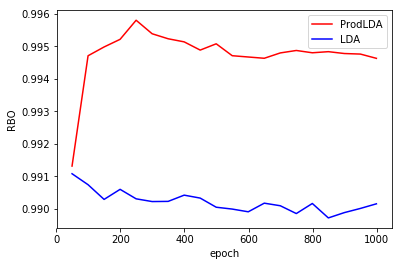

In [8]:
import matplotlib.pyplot as plt
scores_LDA_2k_50 = pd.read_csv('results/scores_50_1000_LDA_2k.csv')
scores_ProdLDA_2k_50 = pd.read_csv('results/scores_50_1000_prodLDA_2k.csv')

plt.plot(scores_ProdLDA_2k_50['epoch'].tolist(), scores_ProdLDA_2k_50['rbo'].tolist(), color='r', linestyle='-', label = 'ProdLDA')

plt.plot(scores_LDA_2k_50['epoch'].tolist(), scores_LDA_2k_50['rbo'].tolist(), color='b', linestyle='-', label = 'LDA')
# plt.plot(scores_LDA['epoch'].tolist(), scores_LDA['train_loss'].tolist(), color='b', linestyle='-', label = 'LDA')
plt.xlabel('epoch')
plt.ylabel('RBO')

plt.legend(loc="figs/lower right")
# plt.title('')
plt.savefig('figs/compare_rbo_50_1000_2k.png')

plt.show()

## 2.  compare vocab sizes and ntopics

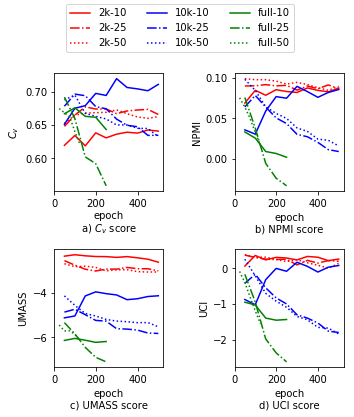

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

scores_ProdLDA_2k_10 = pd.read_csv('results/scores_10_1000_prodLDA_2k.csv')[0:10]
scores_ProdLDA_2k_25 = pd.read_csv('results/scores_25_1000_prodLDA_2k.csv')[0:10]
scores_ProdLDA_2k_50 = pd.read_csv('results/scores_50_1000_prodLDA_2k.csv')[0:10]

scores_ProdLDA_10k_10 = pd.read_csv('results/scores_10_1000_prodLDA_10k.csv')[0:10]
scores_ProdLDA_10k_25 = pd.read_csv('results/scores_25_1000_prodLDA_10k.csv')[0:10]
scores_ProdLDA_10k_50 = pd.read_csv('results/scores_50_1000_prodLDA_10k.csv')[0:10]

scores_ProdLDA_all_10 = pd.read_csv('results/scores_10_500_prodLDA_all.csv')[0:5]
scores_ProdLDA_all_25 = pd.read_csv('results/scores_25_500_prodLDA_all.csv')[0:5]
scores_ProdLDA_all_50 = pd.read_csv('results/scores_50_250_prodLDA_all.csv')[0:5]

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5,5))


# axs = []
# for row in ax:
#     for col in row:
#         axs.append(row)

score= 'npmi'
for ax, score, alpha, name in zip(axs.flatten(), ['cv', 'npmi', 'umass', 'uci'], ['a', 'b', 'c', 'd'], ['$C_v$', 'NPMI', 'UMASS', 'UCI']):
# for ax, score, alpha in zip(axs, ['rbo', 'td'], ['a', 'b']):
#     ax.set_xlabel('epoch'+ '\n'+ alpha+') '+ score.upper() + ' score')
    ax.set_xlabel('epoch'+ '\n'+ alpha+') '+ name + ' score')
    ax.set_ylabel(name)
    ax.plot(scores_ProdLDA_2k_10['epoch'].tolist(), scores_ProdLDA_2k_10[score].tolist(), color='r', linestyle='-', label = '2k-10')
    ax.plot(scores_ProdLDA_2k_25['epoch'].tolist(), scores_ProdLDA_2k_25[score].tolist(), color='r', linestyle='-.', label = '2k-25')
    ax.plot(scores_ProdLDA_2k_50['epoch'].tolist(), scores_ProdLDA_2k_50[score].tolist(), color='r', linestyle=':', label = '2k-50')


    ax.plot(scores_ProdLDA_10k_10['epoch'].tolist(), scores_ProdLDA_10k_10[score].tolist(), color='b', linestyle='-', label = '10k-10')
    ax.plot(scores_ProdLDA_10k_25['epoch'].tolist(), scores_ProdLDA_10k_25[score].tolist(), color='b', linestyle='-.', label = '10k-25')
    ax.plot(scores_ProdLDA_10k_50['epoch'].tolist(), scores_ProdLDA_10k_50[score].tolist(), color='b', linestyle=':', label = '10k-50')

    ax.plot(scores_ProdLDA_all_10['epoch'].tolist(), scores_ProdLDA_all_10[score].tolist(), color='g', linestyle='-', label = 'full-10')
    ax.plot(scores_ProdLDA_all_25['epoch'].tolist(), scores_ProdLDA_all_25[score].tolist(), color='g', linestyle='-.', label = 'full-25')
    ax.plot(scores_ProdLDA_all_50['epoch'].tolist(), scores_ProdLDA_all_50[score].tolist(), color='g', linestyle=':', label = 'full-50')

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncol = 3, bbox_to_anchor=(0.5, 1))
fig.tight_layout(pad=1.0)
# plt.title(score)

# plt.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.savefig('figs/vocab.png',  bbox_extra_artists=(lgd, ), dpi = 300 , bbox_inches='tight')

# plt.savefig('figs/vocab_td.png',  bbox_extra_artists=(lgd, ), dpi = 300 , bbox_inches='tight')

plt.show()

## 3. Compare internal and external topic coherence vs ntopics

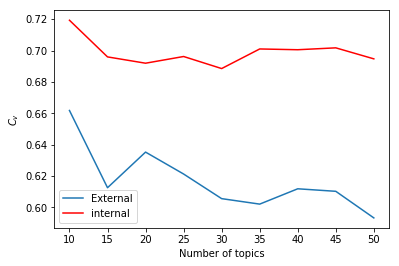

In [24]:
import matplotlib.pyplot as plt

plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [cv_ext_10_10k_, cv_ext_15_10k_, cv_ext_20_10k_, cv_ext_25_10k_, cv_ext_30_10k_, cv_ext_35_10k_ , cv_ext_40_10k_, cv_ext_45_10k_, cv_ext_50_10k_], label = 'External')
plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [cv_int_10_10k_, cv_int_15_10k_, cv_int_20_10k_, cv_int_25_10k_, cv_int_30_10k_, cv_int_35_10k_, cv_int_40_10k_, cv_int_45_10k_, cv_int_50_10k_], label = 'internal', color = 'r')

# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [npmi_ext_10_10k_, npmi_ext_15_10k_, npmi_ext_20_10k_, npmi_ext_25_10k_, npmi_ext_30_10k_, npmi_ext_35_10k_ , npmi_ext_40_10k_, npmi_ext_45_10k_, npmi_ext_50_10k_], label = 'External')
# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [npmi_int_10_10k_, npmi_int_15_10k_, npmi_int_20_10k_, npmi_int_25_10k_, npmi_int_30_10k_, npmi_int_35_10k_, npmi_int_40_10k_, npmi_int_45_10k_, npmi_int_50_10k_], label = 'internal', color = 'r')

# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [umass_ext_10_10k_, umass_ext_15_10k_, umass_ext_20_10k_, umass_ext_25_10k_, umass_ext_30_10k_, umass_ext_35_10k_ , umass_ext_40_10k_, umass_ext_45_10k_, umass_ext_50_10k_], label = 'External')
# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [umass_int_10_10k_, umass_int_15_10k_, umass_int_20_10k_, umass_int_25_10k_, umass_int_30_10k_, umass_int_35_10k_, umass_int_40_10k_, umass_int_45_10k_, umass_int_50_10k_], label = 'internal', color = 'r')

# plt.plot([10,25], [cv_ext_10_2k_, cv_ext_25_2k_])
# plt.plot([10, 25], [cv_int_10_2k_, cv_int_25_2k_], color = 'r')

plt.legend(loc="figs/upper right")
plt.xlabel('Number of topics')
plt.ylabel('$C_v$')
# plt.title('cv')
plt.savefig('figs/ntopics_10k_cv.png')
plt.show()

## dominant topics frequency

In [34]:
topics = ctm.get_topics(25)
scores_prodLDA = pd.read_csv('results/scores_20_250_prodLDA_10k.csv')
regexp = re.compile(r'c\d{7}')

df = pd.DataFrame(columns = ['topic', 'words/entities'])
to_write = ''
for i in range(len(topics)):
    to_write+='topic '+str(i)+':\n'
    new_top =[]
    for w in topics[i]:
        if regexp.search(w):
            try:
                new_top.append('C'+w[1:len(w)] +':'+ linker.umls.cui_to_entity['C'+w[1:len(w)]][1])
            except Exception:
                new_top.append(w)
        else:
            new_top.append(w)
        df.loc[i] =  i, new_top
#     print(topic)
df.head()



/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)
/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)
/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

,topic,words/entities
0,0,"[C0267454:Necrotic enteritis, C0605290:2-chlor..."
1,1,"[C0015967:Fever, C0032285:Pneumonia, C0011900:..."
2,2,"[C0543467:Operative Surgical Procedures, C0025..."
3,3,"[C0032042:Placebos, C0199470:Mechanical ventil..."
4,4,"[policy, crisis, disaster, threat, economic, p..."


In [35]:
topic_doc_dist_test = ctm.get_doc_topic_distribution(dataset=test_set, n_samples = 2)
topic_doc_dist_train = ctm.get_doc_topic_distribution(dataset=dataset, n_samples=2)

In [37]:
mlike_topics = np.argmax(topic_doc_dist_test, axis=1)
diff = np.sort(topic_doc_dist_test, axis = 1)[::-1]
diff = (diff[:, len(df)-1]- diff[:, len(df)-2])/diff[:, len(df)-2]*100
test_df['diff'] = diff
test_df['dominant_topic'] = mlike_topics
freq = pd.Series(mlike_topics).value_counts(sort = False)
freq = freq/sum(freq)*100

In [40]:
test_df['dominant_topic_words'] = ''
for i in range(len(df)):
#     test_df.loc[test_df['dominant_topic']==i, 'dominant_topic_words'].set_value( df.loc[i, 'words/entities'])
    test_df.loc[np.where(test_df['dominant_topic']==i)[0], 'dominant_topic_words'] =  ', '.join(df.loc[i, 'words/entities'])

In [61]:
test_df.to_csv('manual_validation_df.csv')

In [57]:
test_df.loc[test_df['dominant_topic']==2, ].to_csv('mv_test_2.csv')

In [71]:
df.to_csv('topics_words.csv')

Text(0, 0.5, 'Percentage of Documents')

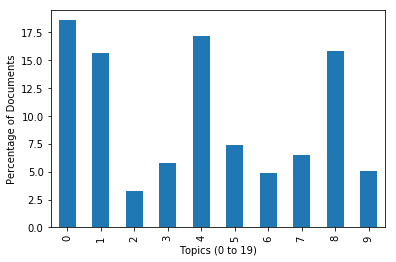

In [38]:
import matplotlib.pyplot as plt
freq.plot.bar()
plt.xlabel('Topics (0 to 19)')
plt.ylabel('Percentage of Documents')
# plt.savefig('figs/freq_topic.png')